# GUO PEIHONG Assignment_2

In [52]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.optimize import minimize

## Task1

In [53]:
cases = pd.read_table('cases.txt', sep=',', header=None)
cases = cases.T
cases.columns = ['Cases']

In [54]:
date = pd.read_table('date.txt', sep=',', header=None)
date = date.T
date.columns = ['Date']

In [55]:
df = pd.concat([date, cases], axis=1)

In [56]:
df

,Date,Cases
0,"Feb 15, 2020",54
1,"Feb 16, 2020",56
2,"Feb 17, 2020",53
3,"Feb 18, 2020",52
4,"Feb 19, 2020",50
...,...,...
1000,"Nov 11, 2022",78431
1001,"Nov 12, 2022",77506
1002,"Nov 13, 2022",76307
1003,"Nov 14, 2022",75291


In [57]:
# Because df.iloc[136] is Jun 30, 2020
df1 = df.iloc[0:137]

In [58]:
df1

,Date,Cases
0,"Feb 15, 2020",54
1,"Feb 16, 2020",56
2,"Feb 17, 2020",53
3,"Feb 18, 2020",52
4,"Feb 19, 2020",50
...,...,...
132,"Jun 26, 2020",6104
133,"Jun 27, 2020",6057
134,"Jun 28, 2020",5925
135,"Jun 29, 2020",5650


In [59]:
# Check for missing values in the data
df1.isnull().sum()

Date     0
Cases    0
dtype: int64

In [60]:
df1['Date'] = pd.to_datetime(df1['Date'])
df1

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,Date,Cases
0,2020-02-15,54
1,2020-02-16,56
2,2020-02-17,53
3,2020-02-18,52
4,2020-02-19,50
...,...,...
132,2020-06-26,6104
133,2020-06-27,6057
134,2020-06-28,5925
135,2020-06-29,5650


In [61]:
# SIR MODEL
def SIR_S(s, i, beta):
    return -beta * s * i

def SIR_I(s, i, beta, gamma):
    return beta * s * i - gamma * i

def SIR_R(i, gamma):
    return gamma * i

In [62]:
# RK4
def RK4(s, i, r, beta, gamma):
    s_all = []
    i_all = []
    r_all = []

    s_all.append(s)
    i_all.append(i)
    r_all.append(r)
    
    
    for ii in range(1,200):
        k1_s = SIR_S(s, i, beta)
        k1_i = SIR_I(s, i, beta, gamma)
        k1_r = SIR_R(i, gamma)
       
        k2_s = SIR_S(s+k1_s/2.0, i+k1_i/2.0, beta)
        k2_i = SIR_I(s+k1_s/2.0, i+k1_i/2.0, beta, gamma)
        k2_r = SIR_R(i+k1_i/2.0, gamma)
        
        k3_s = SIR_S(s+k2_s/2.0, i+k2_i/2.0, beta)
        k3_i = SIR_I(s+k2_s/2.0, i+k2_i/2.0, beta, gamma)
        k3_r = SIR_R(i+k2_i/2.0, gamma)
       
        k4_s = SIR_S(s+k3_s, i+k3_i, beta)
        k4_i = SIR_I(s+k3_s, i+k3_i, beta, gamma)
        k4_r = SIR_R(i+k3_i, gamma)
    
        s = s + k1_s/6.0 + k2_s/3.0 + k3_s/3.0 + k4_s/6.0
        i = i + k1_i/6.0 + k2_i/3.0 + k3_i/3.0 + k4_i/6.0
        r = r + k1_r/6.0 + k2_r/3.0 + k3_r/3.0 + k4_r/6.0
        
        s_all.append(s)
        i_all.append(i)
        r_all.append(r)
    
    return [s_all, i_all, r_all]

### The function for Nelder-Mead Minimizaton

In [63]:
# x0 N*beta
# x1 gamma
# x2 N

def fun(i, i_real):
    def v(x):
        s = x[2] - i
        r = 0
    
        result = RK4(s, i, r, x[0]/x[2], x[1])[1]
        t = 0 
        
        for j in range(len(i_real)):
            t += (i_real[j] - result[j]) ** 2
    
        return t
    return v

### The constraints for Nelder-Mead Minimizaton

In [64]:
def constraint(limit):
    x1min, x1max, x2min, x2max, x3min, x3max = limit
    cons = ({'type': 'ineq', 'fun': lambda x: x[0] - x1min},\
            {'type': 'ineq', 'fun': lambda x: -x[0] + x1max},\
            {'type': 'ineq', 'fun': lambda x: x[1] - x2min},\
            {'type': 'ineq', 'fun': lambda x: -x[1] + x2max},\
            {'type': 'ineq', 'fun': lambda x: x[2] - x3min},\
            {'type': 'ineq', 'fun': lambda x: -x[2] + x3max})
    return cons

In [65]:
# Beta*N and gamma is a value from 0.01 to 1.
# N is a value from 10000 to 1500000.

limit = (0.01, 1, 0.01, 1, 10000, 1500000)

In [66]:
i_real = df1["Cases"]
i = 54

# The initial parameter is randomly set to 0.14, 0.07 and 100000
x0 = np.asarray((0.14, 0.07, 100000))

### Estimate the parameters

In [67]:
cons = constraint(limit)
result = minimize(fun(i, i_real), x0, method='Nelder-Mead',constraints=cons)
print(result.fun)
print(result.success)
print("Beta is  ", result.x[0]/result.x[2])
print("Gamma is ", result.x[1])
print("N is     ", result.x[2])
print("R0 is    ", result.x[0]/result.x[1])

/usr/local/lib/python3.7/dist-packages/scipy/optimize/_minimize.py:542: RuntimeWarning: Method Nelder-Mead cannot handle constraints.
  RuntimeWarning)


245583229.00029948
True
Beta is   1.1994673522257811e-06
Gamma is  0.09759898154426278
N is      150459.17248051934
R0 is     1.849106029364088


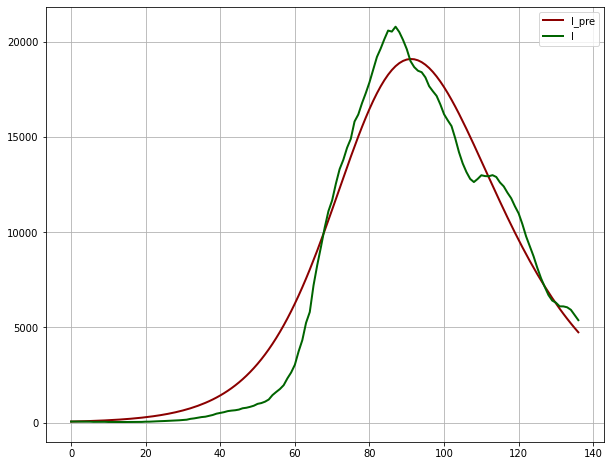

In [68]:
N = result.x[2]
i = 54
s = result.x[2] - 54
r = 0
beta = result.x[0]
gamma = result.x[1]

res_rk4 = RK4(s, i, r, beta/result.x[2], gamma)
plt.figure(figsize=[10, 8])
plt.plot(range(len(df1["Cases"])), res_rk4[1][:len(df1["Cases"])], label='I_pre', color='darkred',linewidth = 2)
plt.plot(range(len(df1["Cases"])), df1["Cases"], label='I', color='darkgreen', linewidth = 2)
plt.legend()
plt.grid()
plt.show()

## Task2

In [69]:
# Because df.iloc[681] is Dec. 27, 2021, df.iloc[764] is Mar. 20, 2022
df2 = df.iloc[681:765]

In [70]:
df2

,Date,Cases
681,"Dec 27, 2021",2696
682,"Dec 28, 2021",2776
683,"Dec 29, 2021",2840
684,"Dec 30, 2021",2877
685,"Dec 31, 2021",2868
...,...,...
760,"Mar 16, 2022",42330
761,"Mar 17, 2022",43037
762,"Mar 18, 2022",37938
763,"Mar 19, 2022",36643


In [71]:
df2.isnull().sum()

Date     0
Cases    0
dtype: int64

In [72]:
df2['Date'] = pd.to_datetime(df2['Date'])
df2

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,Date,Cases
681,2021-12-27,2696
682,2021-12-28,2776
683,2021-12-29,2840
684,2021-12-30,2877
685,2021-12-31,2868
...,...,...
760,2022-03-16,42330
761,2022-03-17,43037
762,2022-03-18,37938
763,2022-03-19,36643


In [73]:
df2 = df2.reset_index(drop=True)
df2

,Date,Cases
0,2021-12-27,2696
1,2021-12-28,2776
2,2021-12-29,2840
3,2021-12-30,2877
4,2021-12-31,2868
...,...,...
79,2022-03-16,42330
80,2022-03-17,43037
81,2022-03-18,37938
82,2022-03-19,36643


In [74]:
i_real = df2["Cases"]
i = 2696
limit = (0.01, 1, 0.01, 1, 10000, 1500000)
x0 = np.asarray((0.15, 0.07, 100000))

In [75]:
cons = constraint(limit)
result = minimize(fun(i, i_real), x0, method='Nelder-Mead',constraints=cons)
print(result.fun)
print(result.success)
print("Beta:  ", result.x[0]/result.x[2])
print("Gamma: ", result.x[1])
print("N:     ", result.x[2])
print("R0:    ", result.x[0]/result.x[1])

/usr/local/lib/python3.7/dist-packages/scipy/optimize/_minimize.py:542: RuntimeWarning: Method Nelder-Mead cannot handle constraints.
  RuntimeWarning)


1900231587.0565925
False
Beta:   2.808888732897834e-08
Gamma:  1.4425554496634598
N:      53854908.74151969
R0:     1.0486421607612155


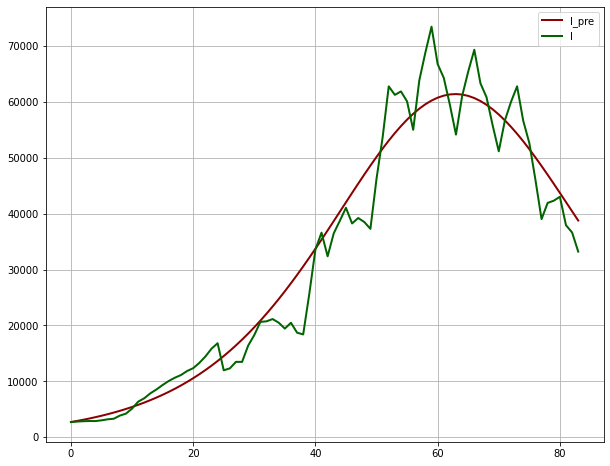

In [51]:
N = result.x[2]
i = 2696
s = result.x[2] - 2696
r = 0
beta = result.x[0]
gamma = result.x[1]

res_rk4 = RK4(s, i, r, beta/result.x[2], gamma)
plt.figure(figsize=[10, 8])
plt.plot(range(len(df2["Cases"])), res_rk4[1][:len(df2["Cases"])], label='I_pre',color='darkred',linewidth = 2)
plt.plot(range(len(df2["Cases"])), df2["Cases"], label='I',color='darkgreen', linewidth = 2)
plt.legend()
plt.grid()
plt.show()